# configuration and training


In [1]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image
from torchvision import models
import numpy as np
from torch.nn import init
from torch import optim
from tqdm import trange,tqdm
import matplotlib
import matplotlib.pyplot as plt


In [2]:
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, scale=1, mask_suffix=''):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'
        self.ids = [file for file in listdir(imgs_dir)]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        mask_file = glob(self.masks_dir + idx)
        img_file = glob(self.imgs_dir + idx)
        # print(self.masks_dir + idx)

        assert len(mask_file) == 1, \
            f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
        mask = Image.open(mask_file[0])
        mask = mask.convert("L")
        img = Image.open(img_file[0])

        assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'
        # mask = np.asarray(list(mask.getdata()))

        img = self.preprocess(img, self.scale)
        mask = self.preprocess(mask, self.scale)
        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': torch.from_numpy(mask).type(torch.FloatTensor)
        }


class CarvanaDataset(BasicDataset):
    def __init__(self, imgs_dir, masks_dir, scale=1):
        super().__init__(imgs_dir, masks_dir, scale, mask_suffix='_mask')

In [3]:
dir_img = './Original/'
dir_mask = './Ground-Truth/'
img_scale = 1
batch_size= 10
val_percent = 0.1
lr = 0.0001
epochs = 15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
dataset = BasicDataset(dir_img, dir_mask, img_scale)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])

In [5]:

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False, drop_last=True)

## filter sizes

In [6]:
class UNet_2Plus(nn.Module):

    def __init__(self, in_channels=3, n_classes=1, feature_scale=4, is_deconv=True, is_batchnorm=True, is_ds=True):
        super(UNet_2Plus, self).__init__()
        self.is_deconv = is_deconv
        self.in_channels = in_channels
        self.is_batchnorm = is_batchnorm
        self.is_ds = is_ds
        self.feature_scale = feature_scale
        filters = [16, 32, 64, 128, 256]
        # filters = [32, 64, 128, 256, 512]
        # filters = [64, 128, 256, 512, 1024]
        # filters = [int(x / self.feature_scale) for x in filters]

        # downsampling
        self.conv00 = unetConv2(self.in_channels, filters[0], self.is_batchnorm)
        self.maxpool0 = nn.MaxPool2d(kernel_size=2)
        self.conv10 = unetConv2(filters[0], filters[1], self.is_batchnorm)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv20 = unetConv2(filters[1], filters[2], self.is_batchnorm)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv30 = unetConv2(filters[2], filters[3], self.is_batchnorm)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2)
        self.conv40 = unetConv2(filters[3], filters[4], self.is_batchnorm)


        # upsampling
        self.up_concat01 = unetUp_origin(filters[1], filters[0], self.is_deconv)
        self.up_concat11 = unetUp_origin(filters[2], filters[1], self.is_deconv)
        self.up_concat21 = unetUp_origin(filters[3], filters[2], self.is_deconv)
        self.up_concat31 = unetUp_origin(filters[4], filters[3], self.is_deconv)

        self.up_concat02 = unetUp_origin(filters[1], filters[0], self.is_deconv, 3)
        self.up_concat12 = unetUp_origin(filters[2], filters[1], self.is_deconv, 3)
        self.up_concat22 = unetUp_origin(filters[3], filters[2], self.is_deconv, 3)

        self.up_concat03 = unetUp_origin(filters[1], filters[0], self.is_deconv, 4)
        self.up_concat13 = unetUp_origin(filters[2], filters[1], self.is_deconv, 4)

        self.up_concat04 = unetUp_origin(filters[1], filters[0], self.is_deconv, 5)

        # final conv (without any concat)
        self.final_1 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_2 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_3 = nn.Conv2d(filters[0], n_classes, 1)
        self.final_4 = nn.Conv2d(filters[0], n_classes, 1)

        # initialise weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init_weights(m, init_type='kaiming')
            elif isinstance(m, nn.BatchNorm2d):
                init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        # column : 0
        X_00 = self.conv00(inputs)
        maxpool0 = self.maxpool0(X_00)
        X_10 = self.conv10(maxpool0)
        maxpool1 = self.maxpool1(X_10)
        X_20 = self.conv20(maxpool1)
        maxpool2 = self.maxpool2(X_20)
        X_30 = self.conv30(maxpool2)
        maxpool3 = self.maxpool3(X_30)
        X_40 = self.conv40(maxpool3)

        # column : 1
        X_01 = self.up_concat01(X_10, X_00)
        X_11 = self.up_concat11(X_20, X_10)
        X_21 = self.up_concat21(X_30, X_20)
        X_31 = self.up_concat31(X_40, X_30)
        # column : 2
        X_02 = self.up_concat02(X_11, X_00, X_01)
        X_12 = self.up_concat12(X_21, X_10, X_11)
        X_22 = self.up_concat22(X_31, X_20, X_21)
        # column : 3
        X_03 = self.up_concat03(X_12, X_00, X_01, X_02)
        X_13 = self.up_concat13(X_22, X_10, X_11, X_12)
        # column : 4
        X_04 = self.up_concat04(X_13, X_00, X_01, X_02, X_03)

        # final layer
        final_1 = self.final_1(X_01)
        final_2 = self.final_2(X_02)
        final_3 = self.final_3(X_03)
        final_4 = self.final_4(X_04)

        final = (final_1 + final_2 + final_3 + final_4) / 4

        if self.is_ds:
            return F.sigmoid(final)
            # return final
        else:
            return F.sigmoid(final_4)
            # return final_4

# model = UNet_2Plus()
# print('# generator parameters:', 1.0 * sum(param.numel() for param in model.parameters())/1000000)
# params = list(model.named_parameters())
# for i in range(len(params)):
#     (name, param) = params[i]
#     print(name)
#     print(param.shape)


In [7]:
class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, is_batchnorm, n=2, ks=3, stride=1, padding=1):
        super(unetConv2, self).__init__()
        self.n = n
        self.ks = ks
        self.stride = stride
        self.padding = padding
        s = stride
        p = padding
        if is_batchnorm:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.BatchNorm2d(out_size),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        else:
            for i in range(1, n + 1):
                conv = nn.Sequential(nn.Conv2d(in_size, out_size, ks, s, p),
                                     nn.ReLU(inplace=True), )
                setattr(self, 'conv%d' % i, conv)
                in_size = out_size

        # initialise the blocks
        for m in self.children():
            init_weights(m, init_type='kaiming')

    def forward(self, inputs):
        x = inputs
        for i in range(1, self.n + 1):
            conv = getattr(self, 'conv%d' % i)
            x = conv(x)

        return x


In [8]:
class unetUp_origin(nn.Module):
    def __init__(self, in_size, out_size, is_deconv, n_concat=2):
        super(unetUp_origin, self).__init__()
        # self.conv = unetConv2(out_size*2, out_size, False)
        if is_deconv:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = unetConv2(in_size + (n_concat - 2) * out_size, out_size, False)
            self.up = nn.UpsamplingBilinear2d(scale_factor=2)

        # initialise the blocks
        for m in self.children():
            if m.__class__.__name__.find('unetConv2') != -1: continue
            init_weights(m, init_type='kaiming')

    def forward(self, inputs0, *input):
        # print(self.n_concat)
        # print(input)
        outputs0 = self.up(inputs0)
        for i in range(len(input)):
            outputs0 = torch.cat([outputs0, input[i]], 1)
        return self.conv(outputs0)


In [9]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    #print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def init_weights(net, init_type='normal'):
    #print('initialization method [%s]' % init_type)
    if init_type == 'normal':
        net.apply(weights_init_normal)
    elif init_type == 'xavier':
        net.apply(weights_init_xavier)
    elif init_type == 'kaiming':
        net.apply(weights_init_kaiming)
    elif init_type == 'orthogonal':
        net.apply(weights_init_orthogonal)
    else:
        raise NotImplementedError('initialization method [%s] is not implemented' % init_type)


In [10]:
def BCE_loss(pred,label):
    bce_loss = nn.BCELoss(size_average=True)
    bce_out = bce_loss(pred, label)
    print("bce_loss:", bce_out.data.cpu().numpy())
    return bce_out

In [11]:
def BCE_log(pred, label):
    BCElog_loss = nn.BCEWithLogitsLoss()
    loss = BCElog_loss(pred, label)
    return loss

In [12]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

def Dice_loss(pred,label):
  dice_loss = DiceLoss()
  dice_out = dice_loss(pred,label)
  print("\ndice_loss",dice_out.data.cpu().numpy())
  return dice_out


In [13]:
from torchsummary import summary
net = UNet_2Plus(in_channels=3, n_classes=1).to(device=device)
summary(net,input_size=(3,384,288), batch_size=1)

D:\ANACONDA\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1260.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
D:\ANACONDA\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 16, 384, 288]             448
       BatchNorm2d-2          [1, 16, 384, 288]              32
              ReLU-3          [1, 16, 384, 288]               0
            Conv2d-4          [1, 16, 384, 288]           2,320
       BatchNorm2d-5          [1, 16, 384, 288]              32
              ReLU-6          [1, 16, 384, 288]               0
         unetConv2-7          [1, 16, 384, 288]               0
         MaxPool2d-8          [1, 16, 192, 144]               0
            Conv2d-9          [1, 32, 192, 144]           4,640
      BatchNorm2d-10          [1, 32, 192, 144]              64
             ReLU-11          [1, 32, 192, 144]               0
           Conv2d-12          [1, 32, 192, 144]           9,248
      BatchNorm2d-13          [1, 32, 192, 144]              64
             ReLU-14          [1, 32, 1

## U-net2p

In [14]:
optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
for epoch in trange(epochs):
  epoch_loss = 0
  step = 0
  for batch in tqdm(train_loader):
    imgs = batch['image'].to(device=device)
    true_masks = batch['mask']
    true_masks = true_masks.to(device=device, dtype=torch.float32)
    masks_pred = net(imgs)
    
    # loss = Dice_loss(masks_pred,true_masks)
    loss = BCE_loss(masks_pred,true_masks)
    # loss = BCE_log(masks_pred,true_masks)
    epoch_loss += loss.item()
    step += 1
    if step % batch_size == 0:
      print(f'\nloss:{loss.item()} mean_loss:{epoch_loss/step}') 
    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_value_(net.parameters(), 0.1)
    optimizer.step()
  torch.save(net.state_dict(), f'./result/U-net2p_lr{lr}_batch_size{batch_size}_epoch{epoch}.pth')

  0%|                                                                                           | 0/56 [00:00<?, ?it/s]D:\ANACONDA\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


bce_loss: 0.8318382



  2%|█▍                                                                                 | 1/56 [00:00<00:37,  1.47it/s]

bce_loss: 0.5326988



  4%|██▉                                                                                | 2/56 [00:01<00:33,  1.60it/s]

bce_loss: 0.3194021



  5%|████▍                                                                              | 3/56 [00:01<00:30,  1.71it/s]

bce_loss: 0.5446808



  7%|█████▉                                                                             | 4/56 [00:02<00:28,  1.81it/s]

bce_loss: 0.3258538



  9%|███████▍                                                                           | 5/56 [00:02<00:27,  1.89it/s]

bce_loss: 0.29454732



 11%|████████▉                                                                          | 6/56 [00:03<00:25,  1.95it/s]

bce_loss: 0.2322095



 12%|██████████▍                                                                        | 7/56 [00:03<00:24,  1.97it/s]

bce_loss: 0.3441142



 14%|███████████▊                                                                       | 8/56 [00:04<00:24,  1.98it/s]

bce_loss: 0.2896022



 16%|█████████████▎                                                                     | 9/56 [00:04<00:23,  2.00it/s]

bce_loss: 0.24662645

loss:0.24662645161151886 mean_loss:0.39615733474493026



 18%|██████████████▋                                                                   | 10/56 [00:05<00:22,  2.02it/s]

bce_loss: 0.29248327



 20%|████████████████                                                                  | 11/56 [00:05<00:22,  2.04it/s]

bce_loss: 0.31903723



 21%|█████████████████▌                                                                | 12/56 [00:06<00:21,  2.03it/s]

bce_loss: 0.24716735



 23%|███████████████████                                                               | 13/56 [00:06<00:20,  2.05it/s]

bce_loss: 0.26770088



 25%|████████████████████▌                                                             | 14/56 [00:06<00:20,  2.04it/s]

bce_loss: 0.2502584



 27%|█████████████████████▉                                                            | 15/56 [00:07<00:19,  2.06it/s]

bce_loss: 0.29206175



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:19,  2.05it/s]

bce_loss: 0.23652714



 30%|████████████████████████▉                                                         | 17/56 [00:08<00:18,  2.06it/s]

bce_loss: 0.23895295



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:18,  2.07it/s]

bce_loss: 0.2294442



 34%|███████████████████████████▊                                                      | 19/56 [00:09<00:17,  2.07it/s]

bce_loss: 0.2486829

loss:0.248682901263237 mean_loss:0.32919447049498557



 36%|█████████████████████████████▎                                                    | 20/56 [00:09<00:17,  2.08it/s]

bce_loss: 0.21550411



 38%|██████████████████████████████▊                                                   | 21/56 [00:10<00:16,  2.08it/s]

bce_loss: 0.20435336



 39%|████████████████████████████████▏                                                 | 22/56 [00:10<00:16,  2.06it/s]

bce_loss: 0.22793217



 41%|█████████████████████████████████▋                                                | 23/56 [00:11<00:15,  2.07it/s]

bce_loss: 0.22447753



 43%|███████████████████████████████████▏                                              | 24/56 [00:11<00:15,  2.07it/s]

bce_loss: 0.2394105



 45%|████████████████████████████████████▌                                             | 25/56 [00:12<00:15,  2.06it/s]

bce_loss: 0.34132695



 46%|██████████████████████████████████████                                            | 26/56 [00:12<00:14,  2.07it/s]

bce_loss: 0.20718662



 48%|███████████████████████████████████████▌                                          | 27/56 [00:13<00:14,  2.06it/s]

bce_loss: 0.23221993



 50%|█████████████████████████████████████████                                         | 28/56 [00:13<00:13,  2.06it/s]

bce_loss: 0.22763638



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:14<00:13,  2.05it/s]

bce_loss: 0.2649042

loss:0.2649042010307312 mean_loss:0.2989613726735115



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:14<00:12,  2.06it/s]

bce_loss: 0.2565056



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:15<00:12,  2.06it/s]

bce_loss: 0.20316744



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:15<00:11,  2.06it/s]

bce_loss: 0.23873234



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:16<00:11,  2.07it/s]

bce_loss: 0.24958278



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:16<00:10,  2.07it/s]

bce_loss: 0.16365959



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:17<00:10,  2.06it/s]

bce_loss: 0.21098301



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:17<00:09,  2.07it/s]

bce_loss: 0.26564828



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:18<00:09,  2.07it/s]

bce_loss: 0.22659887



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:18<00:08,  2.08it/s]

bce_loss: 0.2875054



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:19<00:08,  2.08it/s]

bce_loss: 0.31281537

loss:0.3128153681755066 mean_loss:0.2846009962260723



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:19<00:07,  2.08it/s]

bce_loss: 0.2976227



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:20<00:07,  2.08it/s]

bce_loss: 0.27677873



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:20<00:06,  2.09it/s]

bce_loss: 0.2584779



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:21<00:06,  2.07it/s]

bce_loss: 0.18786398



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:21<00:05,  2.07it/s]

bce_loss: 0.34955108



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:21<00:05,  2.08it/s]

bce_loss: 0.22510858



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:22<00:04,  2.08it/s]

bce_loss: 0.38535556



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:22<00:04,  2.08it/s]

bce_loss: 0.20252



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:23<00:03,  2.08it/s]

bce_loss: 0.2969552



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:23<00:03,  2.08it/s]

bce_loss: 0.29761598

loss:0.29761597514152527 mean_loss:0.28323779106140134



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:24<00:02,  2.07it/s]

bce_loss: 0.26120237



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:24<00:02,  2.07it/s]

bce_loss: 0.27184713



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:25<00:01,  2.05it/s]

bce_loss: 0.26824102



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:25<00:01,  2.06it/s]

bce_loss: 0.21589665



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:26<00:00,  2.07it/s]

bce_loss: 0.21488489



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:26<00:00,  2.08it/s]

bce_loss: 0.27210945



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.22209086



  2%|█▍                                                                                 | 1/56 [00:00<00:23,  2.35it/s]

bce_loss: 0.2292461



  4%|██▉                                                                                | 2/56 [00:00<00:23,  2.34it/s]

bce_loss: 0.2476336



  5%|████▍                                                                              | 3/56 [00:01<00:22,  2.34it/s]

bce_loss: 0.281185



  7%|█████▉                                                                             | 4/56 [00:01<00:22,  2.33it/s]

bce_loss: 0.20377426



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.31it/s]

bce_loss: 0.2658955



 11%|████████▉                                                                          | 6/56 [00:02<00:21,  2.31it/s]

bce_loss: 0.30416447



 12%|██████████▍                                                                        | 7/56 [00:03<00:21,  2.29it/s]

bce_loss: 0.22957514



 14%|███████████▊                                                                       | 8/56 [00:03<00:20,  2.30it/s]

bce_loss: 0.21809362



 16%|█████████████▎                                                                     | 9/56 [00:03<00:20,  2.31it/s]

bce_loss: 0.23784886

loss:0.23784886300563812 mean_loss:0.2439507395029068



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.30it/s]

bce_loss: 0.23995474



 20%|████████████████                                                                  | 11/56 [00:04<00:19,  2.30it/s]

bce_loss: 0.20263578



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.29it/s]

bce_loss: 0.29409108



 23%|███████████████████                                                               | 13/56 [00:05<00:18,  2.30it/s]

bce_loss: 0.25445473



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.28it/s]

bce_loss: 0.21014969



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.27it/s]

bce_loss: 0.21506916



 29%|███████████████████████▍                                                          | 16/56 [00:06<00:17,  2.26it/s]

bce_loss: 0.29950023



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.23it/s]

bce_loss: 0.29121223



 32%|██████████████████████████▎                                                       | 18/56 [00:07<00:17,  2.22it/s]

bce_loss: 0.3288071



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.20it/s]

bce_loss: 0.1980042

loss:0.19800420105457306 mean_loss:0.24866931587457658



 36%|█████████████████████████████▎                                                    | 20/56 [00:08<00:16,  2.21it/s]

bce_loss: 0.2522524



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.21it/s]

bce_loss: 0.22001283



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.22it/s]

bce_loss: 0.25405356



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.23it/s]

bce_loss: 0.28013822



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.24it/s]

bce_loss: 0.26253617



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.24it/s]

bce_loss: 0.2635305



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.24it/s]

bce_loss: 0.21121475



 48%|███████████████████████████████████████▌                                          | 27/56 [00:11<00:12,  2.24it/s]

bce_loss: 0.2236348



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.24it/s]

bce_loss: 0.29644644



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:12<00:12,  2.24it/s]

bce_loss: 0.20241809

loss:0.20241808891296387 mean_loss:0.24798746903737387



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.24it/s]

bce_loss: 0.19864558



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.27it/s]

bce_loss: 0.15935333



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.26it/s]

bce_loss: 0.26446477



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.28it/s]

bce_loss: 0.2817528



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.27it/s]

bce_loss: 0.18894167



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.26it/s]

bce_loss: 0.21186306



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:15<00:08,  2.26it/s]

bce_loss: 0.22253393



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.26it/s]

bce_loss: 0.24642529



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:16<00:07,  2.26it/s]

bce_loss: 0.21113814



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.21420087

loss:0.21420086920261383 mean_loss:0.24097358733415603



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.20675716



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.27it/s]

bce_loss: 0.26749414



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.26it/s]

bce_loss: 0.2002705



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.26it/s]

bce_loss: 0.268336



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.26it/s]

bce_loss: 0.2880623



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:19<00:04,  2.25it/s]

bce_loss: 0.2548129



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.20it/s]

bce_loss: 0.1999142



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:20<00:04,  2.19it/s]

bce_loss: 0.2079019



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.20it/s]

bce_loss: 0.26245284



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:21<00:03,  2.19it/s]

bce_loss: 0.2627735

loss:0.2627735137939453 mean_loss:0.24115437895059585



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.18it/s]

bce_loss: 0.21171722



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.17it/s]

bce_loss: 0.26735133



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.16it/s]

bce_loss: 0.21340653



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.18it/s]

bce_loss: 0.1972047



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.18it/s]

bce_loss: 0.23017092



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.20it/s]

bce_loss: 0.18955564



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.20622867



  2%|█▍                                                                                 | 1/56 [00:00<00:24,  2.24it/s]

bce_loss: 0.15533297



  4%|██▉                                                                                | 2/56 [00:00<00:24,  2.24it/s]

bce_loss: 0.26740128



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.21it/s]

bce_loss: 0.326926



  7%|█████▉                                                                             | 4/56 [00:01<00:23,  2.22it/s]

bce_loss: 0.2930635



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.23it/s]

bce_loss: 0.28148746



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.23it/s]

bce_loss: 0.27163902



 12%|██████████▍                                                                        | 7/56 [00:03<00:21,  2.24it/s]

bce_loss: 0.2663718



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.26it/s]

bce_loss: 0.26783687



 16%|█████████████▎                                                                     | 9/56 [00:04<00:20,  2.25it/s]

bce_loss: 0.25850895

loss:0.25850895047187805 mean_loss:0.2594796493649483



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.22it/s]

bce_loss: 0.18455225



 20%|████████████████                                                                  | 11/56 [00:04<00:19,  2.25it/s]

bce_loss: 0.30857092



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.20516448



 23%|███████████████████                                                               | 13/56 [00:05<00:18,  2.27it/s]

bce_loss: 0.31382507



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.29it/s]

bce_loss: 0.16078432



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.28it/s]

bce_loss: 0.25355405



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.27it/s]

bce_loss: 0.27011126



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.26it/s]

bce_loss: 0.24130662



 32%|██████████████████████████▎                                                       | 18/56 [00:07<00:16,  2.26it/s]

bce_loss: 0.25326082



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.23131676

loss:0.23131676018238068 mean_loss:0.2508621521294117



 36%|█████████████████████████████▎                                                    | 20/56 [00:08<00:16,  2.16it/s]

bce_loss: 0.2710732



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:16,  2.17it/s]

bce_loss: 0.29037407



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:16,  2.12it/s]

bce_loss: 0.19380133



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:15,  2.14it/s]

bce_loss: 0.3029412



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.15it/s]

bce_loss: 0.2774958



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:14,  2.14it/s]

bce_loss: 0.25285542



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.15it/s]

bce_loss: 0.20720118



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:13,  2.15it/s]

bce_loss: 0.24939546



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.18it/s]

bce_loss: 0.19938979



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:13<00:12,  2.18it/s]

bce_loss: 0.24554352

loss:0.24554352462291718 mean_loss:0.2502438003818194



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.20it/s]

bce_loss: 0.20731175



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:14<00:11,  2.22it/s]

bce_loss: 0.2915437



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.23it/s]

bce_loss: 0.18215823



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.24it/s]

bce_loss: 0.22523609



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.24it/s]

bce_loss: 0.1967215



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.24it/s]

bce_loss: 0.2341185



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:08,  2.27it/s]

bce_loss: 0.26951754



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.26it/s]

bce_loss: 0.21163058



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:17<00:07,  2.26it/s]

bce_loss: 0.24206322



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.26it/s]

bce_loss: 0.22646405

loss:0.22646404802799225 mean_loss:0.24485197924077512



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.19267434



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.26it/s]

bce_loss: 0.28035396



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.1986413



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.26it/s]

bce_loss: 0.16562164



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.28it/s]

bce_loss: 0.17237784



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:04,  2.29it/s]

bce_loss: 0.19836818



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.28it/s]

bce_loss: 0.19566679



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:21<00:03,  2.30it/s]

bce_loss: 0.18434203



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.29it/s]

bce_loss: 0.20833807



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:21<00:03,  2.30it/s]

bce_loss: 0.24342157

loss:0.24342156946659088 mean_loss:0.23667769759893417



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.28it/s]

bce_loss: 0.15026921



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.28it/s]

bce_loss: 0.30288592



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.29it/s]

bce_loss: 0.16979146



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.28it/s]

bce_loss: 0.21988992



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.27it/s]

bce_loss: 0.1690406



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.24it/s]

bce_loss: 0.19433449



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.1945553



  2%|█▍                                                                                 | 1/56 [00:00<00:26,  2.06it/s]

bce_loss: 0.14517829



  4%|██▉                                                                                | 2/56 [00:00<00:25,  2.10it/s]

bce_loss: 0.24178211



  5%|████▍                                                                              | 3/56 [00:01<00:24,  2.12it/s]

bce_loss: 0.23149222



  7%|█████▉                                                                             | 4/56 [00:01<00:24,  2.16it/s]

bce_loss: 0.17122684



  9%|███████▍                                                                           | 5/56 [00:02<00:23,  2.14it/s]

bce_loss: 0.25154796



 11%|████████▉                                                                          | 6/56 [00:02<00:23,  2.15it/s]

bce_loss: 0.31112862



 12%|██████████▍                                                                        | 7/56 [00:03<00:22,  2.19it/s]

bce_loss: 0.31094703



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.21it/s]

bce_loss: 0.25994784



 16%|█████████████▎                                                                     | 9/56 [00:04<00:21,  2.23it/s]

bce_loss: 0.24341448

loss:0.2434144765138626 mean_loss:0.23612206876277925



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.21it/s]

bce_loss: 0.23758714



 20%|████████████████                                                                  | 11/56 [00:05<00:20,  2.21it/s]

bce_loss: 0.25203755



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.21it/s]

bce_loss: 0.23006035



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.21it/s]

bce_loss: 0.21835579



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.23it/s]

bce_loss: 0.17820023



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.24it/s]

bce_loss: 0.30299127



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.24it/s]

bce_loss: 0.24448994



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.24it/s]

bce_loss: 0.31324404



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.19738053



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.22738796

loss:0.22738796472549438 mean_loss:0.2381477750837803



 36%|█████████████████████████████▎                                                    | 20/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.17468092



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.27it/s]

bce_loss: 0.3027311



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:14,  2.27it/s]

bce_loss: 0.1484271



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.26it/s]

bce_loss: 0.2237146



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.26it/s]

bce_loss: 0.17891046



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.27it/s]

bce_loss: 0.24449332



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.28it/s]

bce_loss: 0.34227142



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:12,  2.24it/s]

bce_loss: 0.2585389



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.21222852



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:13<00:12,  2.25it/s]

bce_loss: 0.23843321

loss:0.23843321204185486 mean_loss:0.23624616861343384



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.23it/s]

bce_loss: 0.21802089



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.23it/s]

bce_loss: 0.17441748



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.22it/s]

bce_loss: 0.23860465



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.23it/s]

bce_loss: 0.23947872



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.24it/s]

bce_loss: 0.17208531



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.22it/s]

bce_loss: 0.23300754



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:08,  2.23it/s]

bce_loss: 0.20389229



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.21it/s]

bce_loss: 0.28095928



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:17<00:08,  2.22it/s]

bce_loss: 0.20712177



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.23it/s]

bce_loss: 0.20933242

loss:0.2093324214220047 mean_loss:0.23160763531923295



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.19it/s]

bce_loss: 0.18073097



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.20it/s]

bce_loss: 0.28510106



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.20it/s]

bce_loss: 0.24392536



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:06,  2.13it/s]

bce_loss: 0.25265193



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.14it/s]

bce_loss: 0.20600925



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:05,  2.15it/s]

bce_loss: 0.2772078



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.16it/s]

bce_loss: 0.18713972



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:21<00:04,  2.16it/s]

bce_loss: 0.19010116



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.17it/s]

bce_loss: 0.18480717



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:22<00:03,  2.19it/s]

bce_loss: 0.24792565

loss:0.24792565405368805 mean_loss:0.23039810955524445



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.19it/s]

bce_loss: 0.23528449



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:23<00:02,  2.18it/s]

bce_loss: 0.19015661



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.16it/s]

bce_loss: 0.19735931



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.18it/s]

bce_loss: 0.16004367



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.16it/s]

bce_loss: 0.17749058



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.16it/s]

bce_loss: 0.42368332



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.16715059



  2%|█▍                                                                                 | 1/56 [00:00<00:25,  2.12it/s]

bce_loss: 0.37027675



  4%|██▉                                                                                | 2/56 [00:00<00:25,  2.11it/s]

bce_loss: 0.1831151



  5%|████▍                                                                              | 3/56 [00:01<00:24,  2.13it/s]

bce_loss: 0.21133074



  7%|█████▉                                                                             | 4/56 [00:01<00:24,  2.14it/s]

bce_loss: 0.25247258



  9%|███████▍                                                                           | 5/56 [00:02<00:23,  2.15it/s]

bce_loss: 0.25810918



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.18it/s]

bce_loss: 0.21187972



 12%|██████████▍                                                                        | 7/56 [00:03<00:22,  2.20it/s]

bce_loss: 0.23648533



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.19it/s]

bce_loss: 0.24187769



 16%|█████████████▎                                                                     | 9/56 [00:04<00:21,  2.19it/s]

bce_loss: 0.2506838

loss:0.25068381428718567 mean_loss:0.2383381485939026



 18%|██████████████▋                                                                   | 10/56 [00:04<00:21,  2.18it/s]

bce_loss: 0.2537788



 20%|████████████████                                                                  | 11/56 [00:05<00:20,  2.20it/s]

bce_loss: 0.22247566



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.21it/s]

bce_loss: 0.28023434



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.22it/s]

bce_loss: 0.22523685



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.23it/s]

bce_loss: 0.2234093



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.26it/s]

bce_loss: 0.22691746



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.28it/s]

bce_loss: 0.27965036



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.27it/s]

bce_loss: 0.17659202



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:16,  2.26it/s]

bce_loss: 0.2415169



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.28it/s]

bce_loss: 0.19094276

loss:0.19094276428222656 mean_loss:0.23520679622888566



 36%|█████████████████████████████▎                                                    | 20/56 [00:09<00:15,  2.27it/s]

bce_loss: 0.1934479



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.24it/s]

bce_loss: 0.16439208



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.22713378



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.25it/s]

bce_loss: 0.17013712



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.25it/s]

bce_loss: 0.25136012



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.25it/s]

bce_loss: 0.29609796



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.25it/s]

bce_loss: 0.19727989



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.1824722



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.18895316



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:13<00:12,  2.25it/s]

bce_loss: 0.24328028

loss:0.24328027665615082 mean_loss:0.22728968063990276



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.25433588



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.24465922



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.24it/s]

bce_loss: 0.24122235



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.24it/s]

bce_loss: 0.17469561



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.22it/s]

bce_loss: 0.2811731



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.20it/s]

bce_loss: 0.18631826



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:09,  2.19it/s]

bce_loss: 0.18495113



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.19it/s]

bce_loss: 0.2429473



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:17<00:08,  2.21it/s]

bce_loss: 0.1911436



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.22it/s]

bce_loss: 0.20888066

loss:0.20888066291809082 mean_loss:0.2257254384458065



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.23it/s]

bce_loss: 0.23662424



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.24it/s]

bce_loss: 0.22961313



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.24it/s]

bce_loss: 0.22541434



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.24it/s]

bce_loss: 0.24042013



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.25it/s]

bce_loss: 0.20079207



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:04,  2.25it/s]

bce_loss: 0.17389959



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.25it/s]

bce_loss: 0.22183178



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.2602821



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.17166649



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.15565652

loss:0.15565651655197144 mean_loss:0.2229043585062027



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.23it/s]

bce_loss: 0.24431539



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.24it/s]

bce_loss: 0.18023066



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.24it/s]

bce_loss: 0.19717224



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.25it/s]

bce_loss: 0.14643236



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.25it/s]

bce_loss: 0.23021452



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.25it/s]

bce_loss: 0.10028052



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.20076844



  2%|█▍                                                                                 | 1/56 [00:00<00:23,  2.32it/s]

bce_loss: 0.19758207



  4%|██▉                                                                                | 2/56 [00:00<00:24,  2.23it/s]

bce_loss: 0.28706485



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.21it/s]

bce_loss: 0.14950357



  7%|█████▉                                                                             | 4/56 [00:01<00:23,  2.22it/s]

bce_loss: 0.23008382



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.24it/s]

bce_loss: 0.23521635



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.22it/s]

bce_loss: 0.18328531



 12%|██████████▍                                                                        | 7/56 [00:03<00:22,  2.20it/s]

bce_loss: 0.1704915



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.20it/s]

bce_loss: 0.22303896



 16%|█████████████▎                                                                     | 9/56 [00:04<00:21,  2.21it/s]

bce_loss: 0.26699162

loss:0.26699161529541016 mean_loss:0.21440264880657195



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.23it/s]

bce_loss: 0.22140025



 20%|████████████████                                                                  | 11/56 [00:04<00:20,  2.23it/s]

bce_loss: 0.17362267



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.24it/s]

bce_loss: 0.15725327



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.24it/s]

bce_loss: 0.19311158



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.22it/s]

bce_loss: 0.18782105



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.21it/s]

bce_loss: 0.18492042



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:18,  2.20it/s]

bce_loss: 0.28974038



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.20it/s]

bce_loss: 0.2900285



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:17,  2.19it/s]

bce_loss: 0.20981762



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.19it/s]

bce_loss: 0.18925455

loss:0.1892545521259308 mean_loss:0.2120498389005661



 36%|█████████████████████████████▎                                                    | 20/56 [00:09<00:16,  2.18it/s]

bce_loss: 0.19293176



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:16,  2.18it/s]

bce_loss: 0.27022126



 39%|████████████████████████████████▏                                                 | 22/56 [00:10<00:15,  2.15it/s]

bce_loss: 0.23164399



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:15,  2.18it/s]

bce_loss: 0.22015688



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.18it/s]

bce_loss: 0.15297435



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:14,  2.20it/s]

bce_loss: 0.24819027



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.22it/s]

bce_loss: 0.21600184



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:13,  2.23it/s]

bce_loss: 0.21821466



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.23it/s]

bce_loss: 0.28079385



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:13<00:12,  2.23it/s]

bce_loss: 0.14985232

loss:0.14985232055187225 mean_loss:0.21406593173742294



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.21it/s]

bce_loss: 0.3583585



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:14<00:11,  2.22it/s]

bce_loss: 0.2151216



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.23it/s]

bce_loss: 0.21477698



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.24it/s]

bce_loss: 0.19891945



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.24it/s]

bce_loss: 0.18661058



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.22it/s]

bce_loss: 0.25340512



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:08,  2.23it/s]

bce_loss: 0.22821248



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.21it/s]

bce_loss: 0.16469036



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:17<00:08,  2.20it/s]

bce_loss: 0.23339427



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.21it/s]

bce_loss: 0.20944482

loss:0.2094448208808899 mean_loss:0.21712280251085758



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:18<00:07,  2.19it/s]

bce_loss: 0.25668278



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.16it/s]

bce_loss: 0.31040162



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:19<00:06,  2.12it/s]

bce_loss: 0.19587769



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:06,  2.12it/s]

bce_loss: 0.15198472



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:20<00:05,  2.14it/s]

bce_loss: 0.27488905



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:05,  2.17it/s]

bce_loss: 0.2948809



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.20it/s]

bce_loss: 0.18073742



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:21<00:04,  2.21it/s]

bce_loss: 0.21146266



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.22it/s]

bce_loss: 0.18901783



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:22<00:03,  2.23it/s]

bce_loss: 0.19667073

loss:0.19667072594165802 mean_loss:0.2189503499865532



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.17it/s]

bce_loss: 0.26110587



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:23<00:02,  2.08it/s]

bce_loss: 0.20953228



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.11it/s]

bce_loss: 0.177214



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:24<00:01,  2.14it/s]

bce_loss: 0.26451963



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.16it/s]

bce_loss: 0.25765675



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:25<00:00,  2.19it/s]

bce_loss: 0.15487625



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.2435173



  2%|█▍                                                                                 | 1/56 [00:00<00:24,  2.28it/s]

bce_loss: 0.16946253



  4%|██▉                                                                                | 2/56 [00:00<00:23,  2.27it/s]

bce_loss: 0.19788796



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.27it/s]

bce_loss: 0.209364



  7%|█████▉                                                                             | 4/56 [00:01<00:22,  2.26it/s]

bce_loss: 0.18508916



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.26it/s]

bce_loss: 0.24468692



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.25it/s]

bce_loss: 0.2046854



 12%|██████████▍                                                                        | 7/56 [00:03<00:21,  2.26it/s]

bce_loss: 0.17234352



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.26it/s]

bce_loss: 0.2144154



 16%|█████████████▎                                                                     | 9/56 [00:03<00:20,  2.26it/s]

bce_loss: 0.26430333

loss:0.2643033266067505 mean_loss:0.21057555079460144



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.25it/s]

bce_loss: 0.18433477



 20%|████████████████                                                                  | 11/56 [00:04<00:19,  2.25it/s]

bce_loss: 0.2626772



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.17520314



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.18012683



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.22281462



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.2445784



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.22985496



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.23624568



 32%|██████████████████████████▎                                                       | 18/56 [00:07<00:16,  2.25it/s]

bce_loss: 0.27610874



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.2880158

loss:0.28801581263542175 mean_loss:0.2202857829630375



 36%|█████████████████████████████▎                                                    | 20/56 [00:08<00:15,  2.25it/s]

bce_loss: 0.24914166



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.28900474



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.23679122



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.25it/s]

bce_loss: 0.2552942



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.25it/s]

bce_loss: 0.24570403



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.24it/s]

bce_loss: 0.21664284



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.25it/s]

bce_loss: 0.20093146



 48%|███████████████████████████████████████▌                                          | 27/56 [00:11<00:12,  2.25it/s]

bce_loss: 0.22799571



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.24it/s]

bce_loss: 0.2011733



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.1944069

loss:0.1944068968296051 mean_loss:0.22409339100122452



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.24it/s]

bce_loss: 0.18534978



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.24it/s]

bce_loss: 0.23694998



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.30998164



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.19902349



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.18844326



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.21438861



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:15<00:08,  2.25it/s]

bce_loss: 0.19799174



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.25it/s]

bce_loss: 0.26509976



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:16<00:07,  2.25it/s]

bce_loss: 0.19769077



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.2310385

loss:0.23103849589824677 mean_loss:0.22371898144483565



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.2112454



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.25453585



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.16231349



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.26it/s]

bce_loss: 0.23260249



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.26it/s]

bce_loss: 0.18416743



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:19<00:04,  2.28it/s]

bce_loss: 0.15306897



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.27it/s]

bce_loss: 0.13732803



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:20<00:03,  2.27it/s]

bce_loss: 0.21421938



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.24it/s]

bce_loss: 0.22308666



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:21<00:03,  2.22it/s]

bce_loss: 0.19346753

loss:0.19346752762794495 mean_loss:0.2182958897948265



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.21it/s]

bce_loss: 0.19283119



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.20it/s]

bce_loss: 0.17104423



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.21it/s]

bce_loss: 0.16951148



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.23it/s]

bce_loss: 0.16860996



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.24it/s]

bce_loss: 0.2044185



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.22it/s]

bce_loss: 0.13057125



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.16483667



  2%|█▍                                                                                 | 1/56 [00:00<00:24,  2.24it/s]

bce_loss: 0.1982517



  4%|██▉                                                                                | 2/56 [00:00<00:24,  2.19it/s]

bce_loss: 0.26892948



  5%|████▍                                                                              | 3/56 [00:01<00:24,  2.19it/s]

bce_loss: 0.21718113



  7%|█████▉                                                                             | 4/56 [00:01<00:23,  2.21it/s]

bce_loss: 0.29817876



  9%|███████▍                                                                           | 5/56 [00:02<00:23,  2.20it/s]

bce_loss: 0.17823133



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.21it/s]

bce_loss: 0.27257073



 12%|██████████▍                                                                        | 7/56 [00:03<00:22,  2.22it/s]

bce_loss: 0.16688396



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.23it/s]

bce_loss: 0.18039994



 16%|█████████████▎                                                                     | 9/56 [00:04<00:21,  2.24it/s]

bce_loss: 0.2756148

loss:0.27561479806900024 mean_loss:0.22210785001516342



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.24it/s]

bce_loss: 0.20657788



 20%|████████████████                                                                  | 11/56 [00:04<00:20,  2.24it/s]

bce_loss: 0.2040406



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.26793152



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.2019204



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.18113352



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.18138161



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.14662094



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.17877667



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.25003293



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.17704566

loss:0.17704565823078156 mean_loss:0.210827012360096



 36%|█████████████████████████████▎                                                    | 20/56 [00:08<00:15,  2.25it/s]

bce_loss: 0.15072598



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.16303861



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.2574733



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.25it/s]

bce_loss: 0.44472975



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.25it/s]

bce_loss: 0.2375552



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.25it/s]

bce_loss: 0.19651875



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.25it/s]

bce_loss: 0.24748127



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.2112364



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.22830185



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:12<00:11,  2.25it/s]

bce_loss: 0.21583387

loss:0.2158338725566864 mean_loss:0.2189811741312345



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.24205847



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.21478717



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.25201637



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.15525909



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.25744987



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.2030354



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:08,  2.25it/s]

bce_loss: 0.2026551



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.25it/s]

bce_loss: 0.21057653



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:16<00:07,  2.25it/s]

bce_loss: 0.14766261



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.20716074

loss:0.20716074109077454 mean_loss:0.21655241437256337



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.231473



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.26it/s]

bce_loss: 0.22220209



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.20766471



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.25it/s]

bce_loss: 0.22201814



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.25it/s]

bce_loss: 0.1602847



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:04,  2.25it/s]

bce_loss: 0.2506541



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.25it/s]

bce_loss: 0.27007958



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:20<00:03,  2.25it/s]

bce_loss: 0.19829784



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.20774896



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.17237003

loss:0.1723700314760208 mean_loss:0.21609779477119445



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.25it/s]

bce_loss: 0.21867462



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.25it/s]

bce_loss: 0.25045606



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.25it/s]

bce_loss: 0.17542818



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.25it/s]

bce_loss: 0.24012813



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.25it/s]

bce_loss: 0.16819909



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.25it/s]

bce_loss: 0.26807693



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.17633943



  2%|█▍                                                                                 | 1/56 [00:00<00:24,  2.22it/s]

bce_loss: 0.17036851



  4%|██▉                                                                                | 2/56 [00:00<00:24,  2.23it/s]

bce_loss: 0.19240335



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.24it/s]

bce_loss: 0.22575489



  7%|█████▉                                                                             | 4/56 [00:01<00:23,  2.24it/s]

bce_loss: 0.21967109



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.24it/s]

bce_loss: 0.29054216



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.25it/s]

bce_loss: 0.1992715



 12%|██████████▍                                                                        | 7/56 [00:03<00:21,  2.25it/s]

bce_loss: 0.24278672



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.25it/s]

bce_loss: 0.18753175



 16%|█████████████▎                                                                     | 9/56 [00:04<00:20,  2.25it/s]

bce_loss: 0.1500771

loss:0.15007710456848145 mean_loss:0.20547464936971666



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.25it/s]

bce_loss: 0.14634115



 20%|████████████████                                                                  | 11/56 [00:04<00:20,  2.24it/s]

bce_loss: 0.23855025



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.24it/s]

bce_loss: 0.15365717



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.24it/s]

bce_loss: 0.24222937



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.24it/s]

bce_loss: 0.2061589



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.24it/s]

bce_loss: 0.32428882



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.20792243



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.24it/s]

bce_loss: 0.21202564



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:16,  2.24it/s]

bce_loss: 0.17123277



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.23596776

loss:0.235967755317688 mean_loss:0.2096560373902321



 36%|█████████████████████████████▎                                                    | 20/56 [00:08<00:15,  2.27it/s]

bce_loss: 0.15727007



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.27it/s]

bce_loss: 0.18647559



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.26it/s]

bce_loss: 0.16141939



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.26it/s]

bce_loss: 0.21161036



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.26it/s]

bce_loss: 0.27464086



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.25it/s]

bce_loss: 0.13974363



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.25it/s]

bce_loss: 0.2414419



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.2643387



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.230064



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:12<00:11,  2.25it/s]

bce_loss: 0.178176

loss:0.17817600071430206 mean_loss:0.20794337540864943



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.2039562



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.2463001



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.20276877



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.21159934



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.26it/s]

bce_loss: 0.25321072



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.19208814



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:15<00:08,  2.25it/s]

bce_loss: 0.18675743



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.25it/s]

bce_loss: 0.15717542



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:16<00:07,  2.25it/s]

bce_loss: 0.15173492



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.17149182

loss:0.1714918166399002 mean_loss:0.20538460314273835



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.18405981



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.25510016



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.18384635



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.25it/s]

bce_loss: 0.22528489



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.25it/s]

bce_loss: 0.34185925



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:19<00:04,  2.25it/s]

bce_loss: 0.17057091



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.25it/s]

bce_loss: 0.22701144



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:20<00:03,  2.25it/s]

bce_loss: 0.22199962



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.20693588



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.2175791

loss:0.21757909655570984 mean_loss:0.20899263083934783



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.25it/s]

bce_loss: 0.18771908



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.25it/s]

bce_loss: 0.26285744



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.27it/s]

bce_loss: 0.26460323



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.26it/s]

bce_loss: 0.21559863



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:23<00:00,  2.25it/s]

bce_loss: 0.18501753



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.25it/s]

bce_loss: 0.6660412



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.17310587



  2%|█▍                                                                                 | 1/56 [00:00<00:24,  2.29it/s]

bce_loss: 0.20981286



  4%|██▉                                                                                | 2/56 [00:00<00:23,  2.28it/s]

bce_loss: 0.26038432



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.27it/s]

bce_loss: 0.19878413



  7%|█████▉                                                                             | 4/56 [00:01<00:22,  2.26it/s]

bce_loss: 0.2092898



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.26it/s]

bce_loss: 0.21646132



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.26it/s]

bce_loss: 0.20028728



 12%|██████████▍                                                                        | 7/56 [00:03<00:21,  2.26it/s]

bce_loss: 0.22632967



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.26it/s]

bce_loss: 0.19806685



 16%|█████████████▎                                                                     | 9/56 [00:03<00:20,  2.25it/s]

bce_loss: 0.17560379

loss:0.17560379207134247 mean_loss:0.20681258887052537



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.26it/s]

bce_loss: 0.17719795



 20%|████████████████                                                                  | 11/56 [00:04<00:19,  2.25it/s]

bce_loss: 0.23095313



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.3348251



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.20238984



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.17774844



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.20599708



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.18399735



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.21054189



 32%|██████████████████████████▎                                                       | 18/56 [00:07<00:16,  2.25it/s]

bce_loss: 0.23564647



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.1776671

loss:0.17766709625720978 mean_loss:0.21025451123714448



 36%|█████████████████████████████▎                                                    | 20/56 [00:08<00:15,  2.25it/s]

bce_loss: 0.23165831



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.18972456



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.25074315



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.28it/s]

bce_loss: 0.18675624



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.27it/s]

bce_loss: 0.2023067



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.26it/s]

bce_loss: 0.322469



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.26it/s]

bce_loss: 0.23477411



 48%|███████████████████████████████████████▌                                          | 27/56 [00:11<00:12,  2.26it/s]

bce_loss: 0.22240376



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.26it/s]

bce_loss: 0.17286843



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:12<00:12,  2.23it/s]

bce_loss: 0.17564358

loss:0.17564357817173004 mean_loss:0.2131479357679685



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.24it/s]

bce_loss: 0.24453193



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.24it/s]

bce_loss: 0.17364493



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.153234



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.13597324



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.1716983



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.15679306



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:15<00:08,  2.25it/s]

bce_loss: 0.18554625



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.25it/s]

bce_loss: 0.15040351



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:16<00:07,  2.25it/s]

bce_loss: 0.15658589



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.19520418

loss:0.19520418345928192 mean_loss:0.2029513344168663



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.15107869



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.17173158



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.27it/s]

bce_loss: 0.11958997



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.26it/s]

bce_loss: 0.14738725



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.26it/s]

bce_loss: 0.14569853



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:19<00:04,  2.25it/s]

bce_loss: 0.29645953



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.25it/s]

bce_loss: 0.16845521



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:20<00:04,  2.25it/s]

bce_loss: 0.21748811



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.15404476



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:21<00:03,  2.27it/s]

bce_loss: 0.21389915

loss:0.2138991504907608 mean_loss:0.1980777230858803



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.27it/s]

bce_loss: 0.16416313



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.26it/s]

bce_loss: 0.21189015



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.26it/s]

bce_loss: 0.2038236



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.26it/s]

bce_loss: 0.23356052



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:23<00:00,  2.26it/s]

bce_loss: 0.16775385



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.26it/s]

bce_loss: 0.13919325



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.16000609



  2%|█▍                                                                                 | 1/56 [00:00<00:24,  2.28it/s]

bce_loss: 0.20444407



  4%|██▉                                                                                | 2/56 [00:00<00:23,  2.27it/s]

bce_loss: 0.13700065



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.27it/s]

bce_loss: 0.120007254



  7%|█████▉                                                                             | 4/56 [00:01<00:22,  2.26it/s]

bce_loss: 0.14633758



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.28it/s]

bce_loss: 0.23238814



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.27it/s]

bce_loss: 0.22202158



 12%|██████████▍                                                                        | 7/56 [00:03<00:21,  2.28it/s]

bce_loss: 0.1413689



 14%|███████████▊                                                                       | 8/56 [00:03<00:20,  2.29it/s]

bce_loss: 0.1998761



 16%|█████████████▎                                                                     | 9/56 [00:03<00:20,  2.28it/s]

bce_loss: 0.16476884

loss:0.16476884484291077 mean_loss:0.17282192036509514



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.27it/s]

bce_loss: 0.21109378



 20%|████████████████                                                                  | 11/56 [00:04<00:19,  2.26it/s]

bce_loss: 0.16190106



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.26it/s]

bce_loss: 0.21952608



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.26it/s]

bce_loss: 0.18989621



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.16051543



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.18255717



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.26it/s]

bce_loss: 0.20525351



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.17895424



 32%|██████████████████████████▎                                                       | 18/56 [00:07<00:16,  2.25it/s]

bce_loss: 0.18339704



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.19392972

loss:0.19392971694469452 mean_loss:0.18076217211782933



 36%|█████████████████████████████▎                                                    | 20/56 [00:08<00:15,  2.25it/s]

bce_loss: 0.19880857



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.26it/s]

bce_loss: 0.27676633



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.16983202



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.25it/s]

bce_loss: 0.14694154



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.27it/s]

bce_loss: 0.21996796



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.27it/s]

bce_loss: 0.20575278



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.25it/s]

bce_loss: 0.19002713



 48%|███████████████████████████████████████▌                                          | 27/56 [00:11<00:12,  2.25it/s]

bce_loss: 0.1726845



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.1687952



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:12<00:12,  2.25it/s]

bce_loss: 0.16183925

loss:0.16183924674987793 mean_loss:0.1842219573756059



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.1710616



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.24927881



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.1516187



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.23383306



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.15932083



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.25it/s]

bce_loss: 0.15709567



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:15<00:08,  2.24it/s]

bce_loss: 0.2100264



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.25it/s]

bce_loss: 0.18159802



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:16<00:08,  2.25it/s]

bce_loss: 0.2252012



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.2545955

loss:0.25459548830986023 mean_loss:0.18800721298903228



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.25it/s]

bce_loss: 0.2073245



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.21443427



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.16001183



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.25it/s]

bce_loss: 0.18203326



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.25it/s]

bce_loss: 0.20738354



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:19<00:04,  2.24it/s]

bce_loss: 0.19348499



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.24it/s]

bce_loss: 0.15662666



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:20<00:04,  2.24it/s]

bce_loss: 0.18010879



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.24it/s]

bce_loss: 0.2858275



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:21<00:03,  2.25it/s]

bce_loss: 0.22684783

loss:0.2268478274345398 mean_loss:0.1906874333322048



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.25it/s]

bce_loss: 0.17213742



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.25it/s]

bce_loss: 0.26853654



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.27it/s]

bce_loss: 0.1964338



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.26it/s]

bce_loss: 0.23414737



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:23<00:00,  2.25it/s]

bce_loss: 0.21075691



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.25it/s]

bce_loss: 0.27292553



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.23328674



  2%|█▍                                                                                 | 1/56 [00:00<00:23,  2.32it/s]

bce_loss: 0.2135686



  4%|██▉                                                                                | 2/56 [00:00<00:23,  2.27it/s]

bce_loss: 0.22284897



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.27it/s]

bce_loss: 0.16645533



  7%|█████▉                                                                             | 4/56 [00:01<00:22,  2.26it/s]

bce_loss: 0.2329717



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.26it/s]

bce_loss: 0.15362342



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.26it/s]

bce_loss: 0.31125385



 12%|██████████▍                                                                        | 7/56 [00:03<00:21,  2.26it/s]

bce_loss: 0.20575154



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.26it/s]

bce_loss: 0.21678293



 16%|█████████████▎                                                                     | 9/56 [00:03<00:20,  2.26it/s]

bce_loss: 0.13778646

loss:0.13778646290302277 mean_loss:0.209432952105999



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.25it/s]

bce_loss: 0.21225591



 20%|████████████████                                                                  | 11/56 [00:04<00:20,  2.25it/s]

bce_loss: 0.29872894



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.17579405



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.15104207



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.18922763



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.25it/s]

bce_loss: 0.20267439



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.20290652



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.25it/s]

bce_loss: 0.16077434



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.20028858



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.15026312

loss:0.15026311576366425 mean_loss:0.20191425308585167



 36%|█████████████████████████████▎                                                    | 20/56 [00:08<00:16,  2.25it/s]

bce_loss: 0.12948032



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.17934595



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.25it/s]

bce_loss: 0.17241609



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.23it/s]

bce_loss: 0.17253189



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.26it/s]

bce_loss: 0.16587155



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:13,  2.26it/s]

bce_loss: 0.13956468



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.26it/s]

bce_loss: 0.2035737



 48%|███████████████████████████████████████▌                                          | 27/56 [00:11<00:12,  2.26it/s]

bce_loss: 0.1636567



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.26it/s]

bce_loss: 0.24610886



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:12<00:11,  2.25it/s]

bce_loss: 0.1599973

loss:0.15999729931354523 mean_loss:0.1923610697189967



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.16895977



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:13<00:11,  2.25it/s]

bce_loss: 0.11627689



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.25it/s]

bce_loss: 0.17195117



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.26it/s]

bce_loss: 0.1781339



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.26it/s]

bce_loss: 0.15345593



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.26it/s]

bce_loss: 0.23619902



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:08,  2.23it/s]

bce_loss: 0.1804553



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.22it/s]

bce_loss: 0.18275386



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:16<00:08,  2.19it/s]

bce_loss: 0.18208939



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.18it/s]

bce_loss: 0.20022605

loss:0.2002260535955429 mean_loss:0.18853333443403245



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:17<00:07,  2.18it/s]

bce_loss: 0.25825948



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.18it/s]

bce_loss: 0.12597398



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.19it/s]

bce_loss: 0.21052776



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.17it/s]

bce_loss: 0.1822104



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.17it/s]

bce_loss: 0.116118945



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:05,  2.16it/s]

bce_loss: 0.17987868



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.14it/s]

bce_loss: 0.22160225



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:21<00:04,  2.15it/s]

bce_loss: 0.17495793



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.18it/s]

bce_loss: 0.34954673



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:22<00:03,  2.16it/s]

bce_loss: 0.224766

loss:0.22476600110530853 mean_loss:0.19170351073145867



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.16it/s]

bce_loss: 0.20724487



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:22<00:02,  2.17it/s]

bce_loss: 0.17792542



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.17it/s]

bce_loss: 0.21328756



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.19it/s]

bce_loss: 0.20704345



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.19it/s]

bce_loss: 0.26283768



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.18it/s]

bce_loss: 0.14492147



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.24036433



  2%|█▍                                                                                 | 1/56 [00:00<00:23,  2.31it/s]

bce_loss: 0.2112696



  4%|██▉                                                                                | 2/56 [00:00<00:23,  2.29it/s]

bce_loss: 0.27517834



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.28it/s]

bce_loss: 0.24597937



  7%|█████▉                                                                             | 4/56 [00:01<00:23,  2.25it/s]

bce_loss: 0.17959166



  9%|███████▍                                                                           | 5/56 [00:02<00:22,  2.25it/s]

bce_loss: 0.26431283



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.21it/s]

bce_loss: 0.2266176



 12%|██████████▍                                                                        | 7/56 [00:03<00:22,  2.17it/s]

bce_loss: 0.19263765



 14%|███████████▊                                                                       | 8/56 [00:03<00:22,  2.17it/s]

bce_loss: 0.13906692



 16%|█████████████▎                                                                     | 9/56 [00:04<00:21,  2.17it/s]

bce_loss: 0.1822846

loss:0.18228459358215332 mean_loss:0.2157302901148796



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.20it/s]

bce_loss: 0.16744082



 20%|████████████████                                                                  | 11/56 [00:04<00:20,  2.21it/s]

bce_loss: 0.17593911



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.20it/s]

bce_loss: 0.16797237



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.19it/s]

bce_loss: 0.14151579



 25%|████████████████████▌                                                             | 14/56 [00:06<00:19,  2.21it/s]

bce_loss: 0.1579262



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.18it/s]

bce_loss: 0.19327492



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:18,  2.18it/s]

bce_loss: 0.11556902



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.20it/s]

bce_loss: 0.15807974



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:17,  2.22it/s]

bce_loss: 0.14133616



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.22it/s]

bce_loss: 0.29777598

loss:0.2977759838104248 mean_loss:0.19370665065944195



 36%|█████████████████████████████▎                                                    | 20/56 [00:09<00:16,  2.21it/s]

bce_loss: 0.10836712



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.22it/s]

bce_loss: 0.1810716



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.22it/s]

bce_loss: 0.17361213



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.23it/s]

bce_loss: 0.19614027



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.19it/s]

bce_loss: 0.17062478



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:14,  2.18it/s]

bce_loss: 0.21305649



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.18it/s]

bce_loss: 0.16549166



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:13,  2.19it/s]

bce_loss: 0.17764081



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.21it/s]

bce_loss: 0.16291703



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:13<00:12,  2.22it/s]

bce_loss: 0.1600639

loss:0.16006389260292053 mean_loss:0.18610395987828574



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.23it/s]

bce_loss: 0.14984156



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:14<00:11,  2.23it/s]

bce_loss: 0.20106879



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.24it/s]

bce_loss: 0.15977332



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.24it/s]

bce_loss: 0.16127051



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.22it/s]

bce_loss: 0.14556856



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.20it/s]

bce_loss: 0.17932487



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:09,  2.21it/s]

bce_loss: 0.23232956



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.22it/s]

bce_loss: 0.18365404



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:17<00:08,  2.23it/s]

bce_loss: 0.14365575



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.22it/s]

bce_loss: 0.16944507

loss:0.16944506764411926 mean_loss:0.1827262707054615



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:18<00:07,  2.21it/s]

bce_loss: 0.20128663



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.20it/s]

bce_loss: 0.20983846



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:19<00:06,  2.21it/s]

bce_loss: 0.1517621



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.23it/s]

bce_loss: 0.22174212



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.19it/s]

bce_loss: 0.16163519



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:04,  2.21it/s]

bce_loss: 0.16573103



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.20it/s]

bce_loss: 0.22709192



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:21<00:04,  2.21it/s]

bce_loss: 0.2804433



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.23it/s]

bce_loss: 0.16874152



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:22<00:03,  2.21it/s]

bce_loss: 0.1831609

loss:0.1831609010696411 mean_loss:0.18560968041419984



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.22it/s]

bce_loss: 0.1439833



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:23<00:02,  2.21it/s]

bce_loss: 0.19293599



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.20it/s]

bce_loss: 0.15864447



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.19it/s]

bce_loss: 0.23938344



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.21it/s]

bce_loss: 0.12726174



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.20it/s]

bce_loss: 0.15274826



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.23117512



  2%|█▍                                                                                 | 1/56 [00:00<00:24,  2.23it/s]

bce_loss: 0.20448478



  4%|██▉                                                                                | 2/56 [00:01<00:26,  2.04it/s]

bce_loss: 0.14927368



  5%|████▍                                                                              | 3/56 [00:01<00:26,  1.98it/s]

bce_loss: 0.16046427



  7%|█████▉                                                                             | 4/56 [00:02<00:25,  2.05it/s]

bce_loss: 0.21996386



  9%|███████▍                                                                           | 5/56 [00:02<00:24,  2.11it/s]

bce_loss: 0.15623976



 11%|████████▉                                                                          | 6/56 [00:02<00:23,  2.13it/s]

bce_loss: 0.14359617



 12%|██████████▍                                                                        | 7/56 [00:03<00:22,  2.14it/s]

bce_loss: 0.15922204



 14%|███████████▊                                                                       | 8/56 [00:03<00:22,  2.18it/s]

bce_loss: 0.19190562



 16%|█████████████▎                                                                     | 9/56 [00:04<00:21,  2.20it/s]

bce_loss: 0.23058414

loss:0.23058414459228516 mean_loss:0.1846909448504448



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.19it/s]

bce_loss: 0.21572886



 20%|████████████████                                                                  | 11/56 [00:05<00:20,  2.19it/s]

bce_loss: 0.22735304



 21%|█████████████████▌                                                                | 12/56 [00:05<00:20,  2.19it/s]

bce_loss: 0.19817014



 23%|███████████████████                                                               | 13/56 [00:06<00:19,  2.20it/s]

bce_loss: 0.15056719



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.21it/s]

bce_loss: 0.16367765



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.22it/s]

bce_loss: 0.1692036



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:17,  2.23it/s]

bce_loss: 0.18922514



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.21it/s]

bce_loss: 0.15008768



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:17,  2.18it/s]

bce_loss: 0.17372862



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.20it/s]

bce_loss: 0.15951131

loss:0.15951131284236908 mean_loss:0.1822081334888935



 36%|█████████████████████████████▎                                                    | 20/56 [00:09<00:16,  2.21it/s]

bce_loss: 0.18949439



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:15,  2.22it/s]

bce_loss: 0.20811935



 39%|████████████████████████████████▏                                                 | 22/56 [00:10<00:15,  2.23it/s]

bce_loss: 0.15049529



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:14,  2.21it/s]

bce_loss: 0.14272995



 43%|███████████████████████████████████▏                                              | 24/56 [00:11<00:14,  2.20it/s]

bce_loss: 0.23663239



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:14,  2.19it/s]

bce_loss: 0.24086832



 46%|██████████████████████████████████████                                            | 26/56 [00:12<00:13,  2.16it/s]

bce_loss: 0.20631923



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:13,  2.14it/s]

bce_loss: 0.15198839



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:13,  2.13it/s]

bce_loss: 0.17927033



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:13<00:12,  2.12it/s]

bce_loss: 0.15257423

loss:0.15257422626018524 mean_loss:0.18342181742191316



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:12,  2.14it/s]

bce_loss: 0.17410694



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:14<00:11,  2.15it/s]

bce_loss: 0.16958909



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:11,  2.14it/s]

bce_loss: 0.21934406



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:15<00:10,  2.15it/s]

bce_loss: 0.1454036



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:10,  2.18it/s]

bce_loss: 0.15083104



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:16<00:09,  2.17it/s]

bce_loss: 0.2532239



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:09,  2.17it/s]

bce_loss: 0.17280814



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:17<00:08,  2.17it/s]

bce_loss: 0.11205533



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:17<00:08,  2.19it/s]

bce_loss: 0.23309104



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:18<00:07,  2.20it/s]

bce_loss: 0.18542224

loss:0.18542224168777466 mean_loss:0.18296324759721755



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:18<00:07,  2.22it/s]

bce_loss: 0.19062601



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.23it/s]

bce_loss: 0.19874072



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:19<00:06,  2.23it/s]

bce_loss: 0.1632146



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.23it/s]

bce_loss: 0.16893119



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:20<00:05,  2.22it/s]

bce_loss: 0.13914594



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:05,  2.20it/s]

bce_loss: 0.18202353



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:21<00:04,  2.19it/s]

bce_loss: 0.1369057



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:21<00:04,  2.20it/s]

bce_loss: 0.1561



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:22<00:03,  2.19it/s]

bce_loss: 0.20460074



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:22<00:03,  2.21it/s]

bce_loss: 0.17585833

loss:0.17585833370685577 mean_loss:0.18069353312253952



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.20it/s]

bce_loss: 0.16651179



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:23<00:02,  2.19it/s]

bce_loss: 0.16074824



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.21it/s]

bce_loss: 0.17134733



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:24<00:01,  2.22it/s]

bce_loss: 0.14896181



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.23it/s]

bce_loss: 0.18682814



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:25<00:00,  2.21it/s]

bce_loss: 0.07494398



  0%|                                                                                           | 0/56 [00:00<?, ?it/s]

bce_loss: 0.14291303



  2%|█▍                                                                                 | 1/56 [00:00<00:24,  2.23it/s]

bce_loss: 0.11179296



  4%|██▉                                                                                | 2/56 [00:00<00:24,  2.22it/s]

bce_loss: 0.11211599



  5%|████▍                                                                              | 3/56 [00:01<00:23,  2.22it/s]

bce_loss: 0.20806777



  7%|█████▉                                                                             | 4/56 [00:01<00:23,  2.24it/s]

bce_loss: 0.12377331



  9%|███████▍                                                                           | 5/56 [00:02<00:23,  2.22it/s]

bce_loss: 0.1966199



 11%|████████▉                                                                          | 6/56 [00:02<00:22,  2.20it/s]

bce_loss: 0.12341448



 12%|██████████▍                                                                        | 7/56 [00:03<00:22,  2.19it/s]

bce_loss: 0.117259465



 14%|███████████▊                                                                       | 8/56 [00:03<00:21,  2.21it/s]

bce_loss: 0.13772926



 16%|█████████████▎                                                                     | 9/56 [00:04<00:21,  2.23it/s]

bce_loss: 0.13443454

loss:0.1344345360994339 mean_loss:0.14081206917762756



 18%|██████████████▋                                                                   | 10/56 [00:04<00:20,  2.24it/s]

bce_loss: 0.13597205



 20%|████████████████                                                                  | 11/56 [00:04<00:20,  2.24it/s]

bce_loss: 0.16419147



 21%|█████████████████▌                                                                | 12/56 [00:05<00:19,  2.24it/s]

bce_loss: 0.17723021



 23%|███████████████████                                                               | 13/56 [00:05<00:19,  2.25it/s]

bce_loss: 0.16298658



 25%|████████████████████▌                                                             | 14/56 [00:06<00:18,  2.22it/s]

bce_loss: 0.19463645



 27%|█████████████████████▉                                                            | 15/56 [00:06<00:18,  2.21it/s]

bce_loss: 0.15846972



 29%|███████████████████████▍                                                          | 16/56 [00:07<00:18,  2.22it/s]

bce_loss: 0.1809532



 30%|████████████████████████▉                                                         | 17/56 [00:07<00:17,  2.23it/s]

bce_loss: 0.141973



 32%|██████████████████████████▎                                                       | 18/56 [00:08<00:17,  2.19it/s]

bce_loss: 0.13651727



 34%|███████████████████████████▊                                                      | 19/56 [00:08<00:16,  2.18it/s]

bce_loss: 0.20173721

loss:0.2017372101545334 mean_loss:0.15313939303159713



 36%|█████████████████████████████▎                                                    | 20/56 [00:09<00:16,  2.17it/s]

bce_loss: 0.17649615



 38%|██████████████████████████████▊                                                   | 21/56 [00:09<00:16,  2.17it/s]

bce_loss: 0.21382925



 39%|████████████████████████████████▏                                                 | 22/56 [00:09<00:15,  2.17it/s]

bce_loss: 0.20967059



 41%|█████████████████████████████████▋                                                | 23/56 [00:10<00:15,  2.19it/s]

bce_loss: 0.18560252



 43%|███████████████████████████████████▏                                              | 24/56 [00:10<00:14,  2.18it/s]

bce_loss: 0.2252183



 45%|████████████████████████████████████▌                                             | 25/56 [00:11<00:14,  2.20it/s]

bce_loss: 0.16402356



 46%|██████████████████████████████████████                                            | 26/56 [00:11<00:13,  2.21it/s]

bce_loss: 0.21638612



 48%|███████████████████████████████████████▌                                          | 27/56 [00:12<00:13,  2.23it/s]

bce_loss: 0.19798692



 50%|█████████████████████████████████████████                                         | 28/56 [00:12<00:12,  2.21it/s]

bce_loss: 0.24456955



 52%|██████████████████████████████████████████▍                                       | 29/56 [00:13<00:12,  2.22it/s]

bce_loss: 0.17646857

loss:0.17646856606006622 mean_loss:0.1691013127565384



 54%|███████████████████████████████████████████▉                                      | 30/56 [00:13<00:11,  2.23it/s]

bce_loss: 0.16992679



 55%|█████████████████████████████████████████████▍                                    | 31/56 [00:14<00:11,  2.21it/s]

bce_loss: 0.18627732



 57%|██████████████████████████████████████████████▊                                   | 32/56 [00:14<00:10,  2.23it/s]

bce_loss: 0.17989406



 59%|████████████████████████████████████████████████▎                                 | 33/56 [00:14<00:10,  2.24it/s]

bce_loss: 0.13418695



 61%|█████████████████████████████████████████████████▊                                | 34/56 [00:15<00:09,  2.24it/s]

bce_loss: 0.141516



 62%|███████████████████████████████████████████████████▎                              | 35/56 [00:15<00:09,  2.22it/s]

bce_loss: 0.17406087



 64%|████████████████████████████████████████████████████▋                             | 36/56 [00:16<00:08,  2.23it/s]

bce_loss: 0.18632829



 66%|██████████████████████████████████████████████████████▏                           | 37/56 [00:16<00:08,  2.23it/s]

bce_loss: 0.13371423



 68%|███████████████████████████████████████████████████████▋                          | 38/56 [00:17<00:08,  2.22it/s]

bce_loss: 0.17015012



 70%|█████████████████████████████████████████████████████████                         | 39/56 [00:17<00:07,  2.23it/s]

bce_loss: 0.15425776

loss:0.15425775945186615 mean_loss:0.1675837941467762



 71%|██████████████████████████████████████████████████████████▌                       | 40/56 [00:18<00:07,  2.24it/s]

bce_loss: 0.16478232



 73%|████████████████████████████████████████████████████████████                      | 41/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.20160529



 75%|█████████████████████████████████████████████████████████████▌                    | 42/56 [00:18<00:06,  2.25it/s]

bce_loss: 0.15326074



 77%|██████████████████████████████████████████████████████████████▉                   | 43/56 [00:19<00:05,  2.25it/s]

bce_loss: 0.12538181



 79%|████████████████████████████████████████████████████████████████▍                 | 44/56 [00:19<00:05,  2.24it/s]

bce_loss: 0.12118915



 80%|█████████████████████████████████████████████████████████████████▉                | 45/56 [00:20<00:04,  2.25it/s]

bce_loss: 0.21520604



 82%|███████████████████████████████████████████████████████████████████▎              | 46/56 [00:20<00:04,  2.22it/s]

bce_loss: 0.13891011



 84%|████████████████████████████████████████████████████████████████████▊             | 47/56 [00:21<00:04,  2.23it/s]

bce_loss: 0.13269942



 86%|██████████████████████████████████████████████████████████████████████▎           | 48/56 [00:21<00:03,  2.22it/s]

bce_loss: 0.15080334



 88%|███████████████████████████████████████████████████████████████████████▊          | 49/56 [00:22<00:03,  2.18it/s]

bce_loss: 0.22247243

loss:0.2224724292755127 mean_loss:0.1665932482481003



 89%|█████████████████████████████████████████████████████████████████████████▏        | 50/56 [00:22<00:02,  2.16it/s]

bce_loss: 0.13537379



 91%|██████████████████████████████████████████████████████████████████████████▋       | 51/56 [00:23<00:02,  2.18it/s]

bce_loss: 0.28808758



 93%|████████████████████████████████████████████████████████████████████████████▏     | 52/56 [00:23<00:01,  2.20it/s]

bce_loss: 0.23104328



 95%|█████████████████████████████████████████████████████████████████████████████▌    | 53/56 [00:23<00:01,  2.17it/s]

bce_loss: 0.1707293



 96%|███████████████████████████████████████████████████████████████████████████████   | 54/56 [00:24<00:00,  2.17it/s]

bce_loss: 0.14741538



 98%|████████████████████████████████████████████████████████████████████████████████▌ | 55/56 [00:24<00:00,  2.18it/s]

bce_loss: 0.18087645



100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [06:14<00:00, 24.97s/it]


In [15]:
def dice_coeff(input, target):

    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)

    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [16]:
"""Evaluation without the densecrf with the dice coefficient"""
net.eval()
n_val = len(val_loader)  # the number of batch
tot = 0
index=0
for batch in tqdm(val_loader):
# batch = next(iter(val_loader))
  imgs, true_masks = batch['image'], batch['mask']
  imgs = imgs.to(device=device, dtype=torch.float32)
  true_masks = true_masks.to(device=device, dtype=torch.float32)
  with torch.no_grad():
      mask_pred = net(imgs)
      pred = torch.sigmoid(mask_pred)
      # pred = (pred > 0.5).float()
      single_dice = dice_coeff(pred, true_masks).item()
      tot += single_dice
      index += 1
      print(f'\nsingle_dice:{single_dice} mean_dice:{tot/index}')




  0%|                                                                                            | 0/6 [00:00<?, ?it/s]


single_dice:0.7771905064582825 mean_dice:0.7771905064582825


 17%|██████████████                                                                      | 1/6 [00:00<00:01,  3.80it/s]


single_dice:0.6563681364059448 mean_dice:0.7167793214321136


 33%|████████████████████████████                                                        | 2/6 [00:00<00:01,  3.70it/s]


single_dice:0.6700084209442139 mean_dice:0.7011890212694804


 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00,  3.72it/s]


single_dice:0.6332318186759949 mean_dice:0.684199720621109


 67%|████████████████████████████████████████████████████████                            | 4/6 [00:01<00:00,  3.70it/s]


single_dice:0.7931008338928223 mean_dice:0.7059799432754517


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:01<00:00,  3.71it/s]


single_dice:0.6792495846748352 mean_dice:0.7015248835086823


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  3.77it/s]


# Eval

In [17]:
pre_dir='./Present-src/'
pre_mask='./Present-mask/'
present_dataset = BasicDataset(pre_dir, pre_mask, img_scale)
present_loader = DataLoader(present_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=False, drop_last=False)


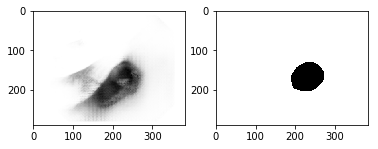

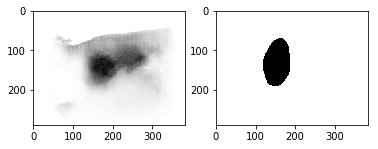

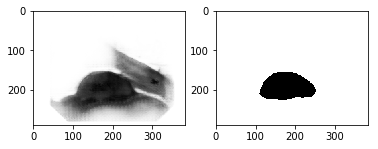

In [18]:
model_name ='U-net2p'
lr = 0.0001
batch_size = 10
epoch=15
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_2Plus(in_channels=3, n_classes=1).to(device=device)
# model = torch.load(f'/content/drive/MyDrive/Dataset/CVC-ClinicDB/Result_models/{model_name}_lr{lr}_batch_size{batch_size}_epoch{epoch-1}.pth')
model.load_state_dict(torch.load(f'./result/{model_name}_lr{lr}_batch_size{batch_size}_epoch{epoch-2}.pth'))
model.eval()
for batch in present_loader:
  tmp,tmp_mask = batch['image'],batch['mask']
  # print(tmp.size)
  tmp = tmp.to(device=device, dtype=torch.float32)
  tmp_mask = tmp_mask.to(device=device, dtype=torch.float32)
  with torch.no_grad():
    mask_pred = model(tmp)
    pred = torch.sigmoid(mask_pred).cpu()
    tmp_mask=tmp_mask.cpu()
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(pred[ :, :, :].squeeze(), cmap=plt.cm.gray_r)

    plt.subplot(1,2,2)
    plt.imshow(tmp_mask[ :, :, :].squeeze(), cmap=plt.cm.gray_r)
    plt.show()